In [121]:
import os
os.environ["OMP_NUM_THREADS"] = "32"

from graph_tool.all import *
import pandas as pd
import numpy as np
import scipy as sp
from sklearn.covariance import LedoitWolf, OAS
import matplotlib.pyplot as plt
import matplotlib.cm as mpl
import seaborn as sns
import statsmodels.api as sm
from multipy.fdr import qvalue
from multipy.fdr import lsu

import dill

import sys
sys.path.insert(0, '/Genomics/argo/users/damelo/projects/NEX-HS_C-GxE/SBM')

import fit_sbm
import trim_networks
import export_blocks

In [143]:
block_path = "../../data/output/SBM/gtex/MCMC/blocks/fdr-1e-3/"
blocks = os.listdir(block_path)
blocks = list(filter(lambda x:'.dill' in x, blocks))
block_adress = [block_path + i for i in blocks]
bs_list = []
for i in block_adress:
    with open (i, "rb") as fh:
        bs_list.append(dill.load(fh)[0:6])
blocks

['TESTIS.dill',
 'LUNG.dill',
 'SPLEEN.dill',
 'OVARY.dill',
 'COLON.dill',
 'THYROID.dill',
 'MUSCLE.dill',
 'HEART.dill',
 'LIVER.dill',
 'BRAIN.dill']

In [144]:
for i, block_i in enumerate(blocks):
    for j, block_j in enumerate(blocks):
        print(block_i, block_j, nested_partition_overlap(bs_list[i] ,bs_list[j]))

TESTIS.dill TESTIS.dill 1.0
TESTIS.dill LUNG.dill 0.1182857802934042
TESTIS.dill SPLEEN.dill 0.11035042933395223
TESTIS.dill OVARY.dill 0.08865165931770713
TESTIS.dill COLON.dill 0.12163729128014844
TESTIS.dill THYROID.dill 0.1236304924460847
TESTIS.dill MUSCLE.dill 0.11669179909523253
TESTIS.dill HEART.dill 0.11731325998841924
TESTIS.dill LIVER.dill 0.10211185889997676
TESTIS.dill BRAIN.dill 0.12081934961231344
LUNG.dill TESTIS.dill 0.11840129375072195
LUNG.dill LUNG.dill 1.0
LUNG.dill SPLEEN.dill 0.1409915636195539
LUNG.dill OVARY.dill 0.10932624523286716
LUNG.dill COLON.dill 0.14541464541464544
LUNG.dill THYROID.dill 0.1657827991699331
LUNG.dill MUSCLE.dill 0.13116838090835548
LUNG.dill HEART.dill 0.14226279902923844
LUNG.dill LIVER.dill 0.12180746561886047
LUNG.dill BRAIN.dill 0.12504333757078467
SPLEEN.dill TESTIS.dill 0.11023439313065675
SPLEEN.dill LUNG.dill 0.1411071304749798
SPLEEN.dill SPLEEN.dill 1.0
SPLEEN.dill OVARY.dill 0.10913795131130188
SPLEEN.dill COLON.dill 0.1323973

In [146]:
graph_path = "../../data/output/SBM/gtex/trimmed_graph/fdr-1e-3/"
os.listdir(graph_path)

['LIVER.xml.gz',
 'THYROID.xml.gz',
 'MUSCLE.xml.gz',
 'LUNG.xml.gz',
 'HEART.xml.gz',
 'BRAIN.xml.gz',
 'OVARY.xml.gz',
 'SPLEEN.xml.gz',
 'COLON.xml.gz',
 'TESTIS.xml.gz']

In [147]:
with open (block_path + "BRAIN.dill", "rb") as fh:
    bs = dill.load(fh)[0:6]

In [149]:
g = load_graph(graph_path + "BRAIN.xml.gz")
corr = g.edge_properties["spearman"]

g.ep.z_s = g.new_edge_property("double", (2*np.arctanh(corr.a)))

In [151]:
state = minimize_nested_blockmodel_dl(g, init_bs=bs, 
                                      state_args=dict(recs=[g.ep.z_s],
                                                      rec_types=["real-normal"]))

In [ ]:
def create_nestedBlock_df(g, corr, state):
    genes = g.vertex_properties["genes"]
    nested_block_df = pd.DataFrame(columns=('Gene', "Degree", "E_corr", 'B1', "B2", "B3", "B4", "B5", "B6", "B7"))
    for v in g.vertex_index:
        line = [genes[v]]
        line.append(g.get_total_degrees([v])[0])
        line.append(np.mean(np.abs(g.get_all_edges(v, [corr] )[:,2])))
        [line.append(i) for i in get_group(v, state)]
        nested_block_df.loc[v] = line
    return nested_block_df

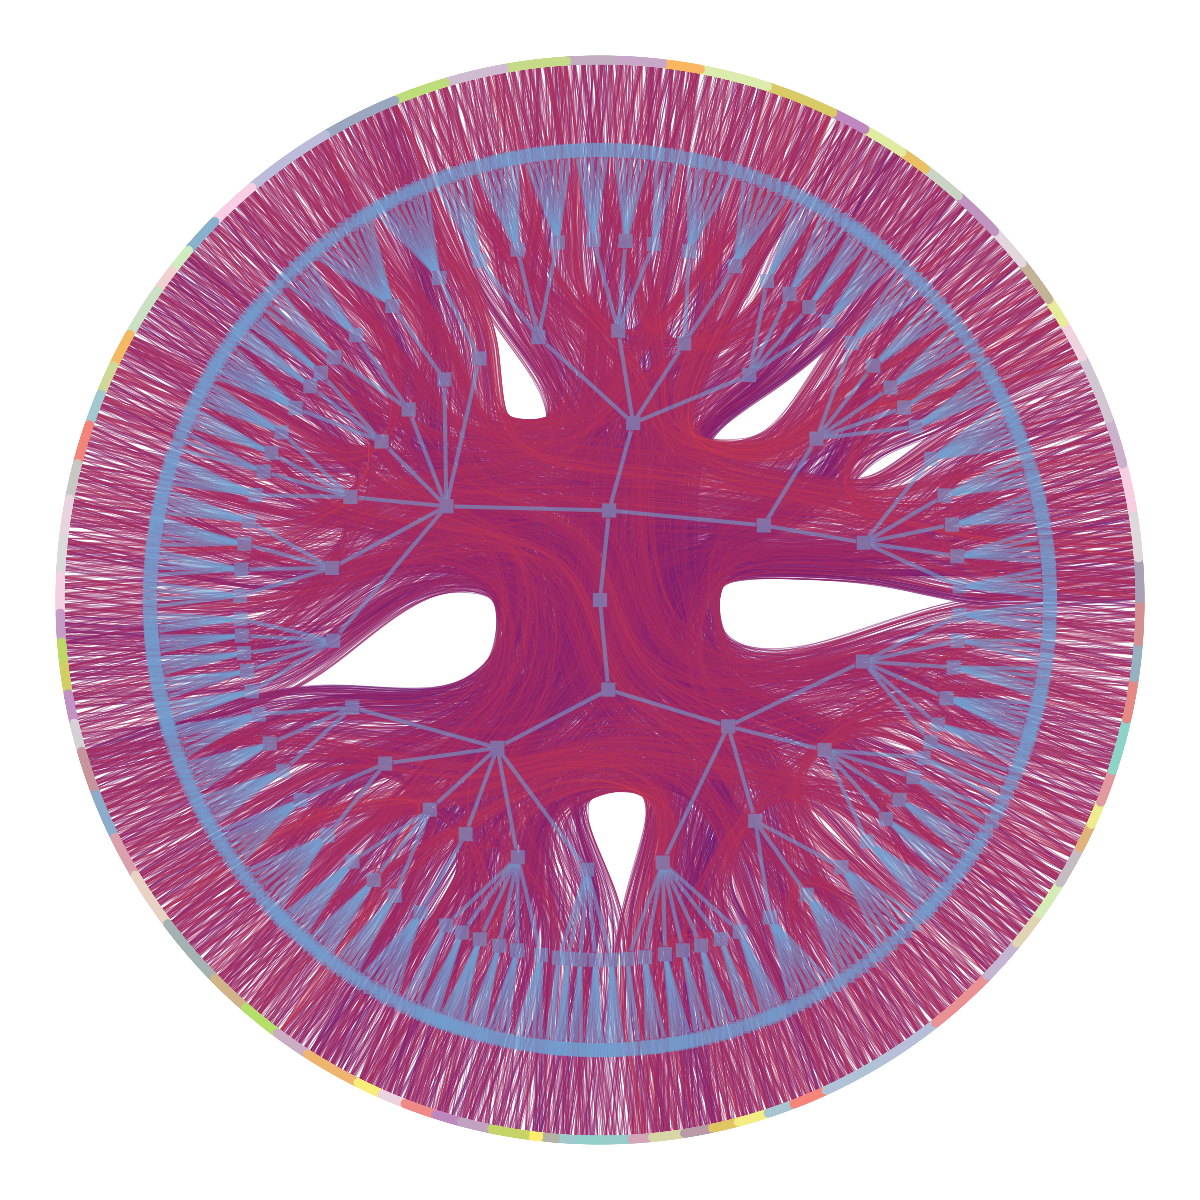

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f34141b17b0, at 0x7f340e0a67a0>,
 <Graph object, directed, with 6438 vertices and 6437 edges, at 0x7f340b7c0910>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f340b7c0910, at 0x7f340e0a67d0>)

In [81]:
g.vp.level_1 = g.new_vertex_property("double", state.get_bs()[1][state.get_bs()[0]])
state.draw(eorder=g.ep.z_s,
           #edge_pen_width = gf_head.ep.z_s,
           edge_color=prop_to_size(g.ep.z_s, mi=0, ma=1, power=0.5, log=False),
           ecmap=(mpl.inferno, 0.6), 
           edge_gradient=[], 
           vertex_size = 4,
           hvertex_size = 10,
           hedge_pen_width = 2,
           vertex_color = g.vp.level_1,
           vertex_fill_color = g.vp.level_1,
           subsample_edges = 5000)

In [52]:
with open (block_path + "14_TESTIS.dill", "rb") as fh:
    bs2 = dill.load(fh)[0:5]
bs2

[PropertyArray([  0,   1,   2, ...,  52, 189,   0], dtype=int32),
 PropertyArray([ 0,  1,  1,  2,  3,  4,  5,  6,  2,  6,  5,  7,  6,  7,  8,
                 9,  9, 10, 11, 12,  5,  3, 13, 14, 14, 15,  9, 16, 17, 18,
                19, 20,  0, 21, 22, 23, 24, 25, 26,  8, 27, 23, 28, 29, 30,
                31,  4, 29, 32, 33,  7,  4, 34, 21, 29, 35,  9, 36, 27, 12,
                 0, 25, 37, 17,  3, 38,  8, 17, 11, 32, 30, 39, 40, 41, 42,
                40,  4, 20, 43, 29, 31, 16, 44, 45, 19, 26, 46, 20, 23, 22,
                47, 48, 38, 49, 22, 46,  3, 42, 50, 51, 15, 37, 12,  6, 52,
                46, 50, 26, 17, 21, 34, 20, 28, 14, 33, 19,  0, 43, 42, 21,
                 8, 15,  2, 11, 53, 54, 43, 55, 43, 17, 44, 56, 57, 38, 10,
                55, 54, 55, 49, 58, 31, 39, 54, 38, 16, 39, 27, 40, 24, 19,
                25, 42, 34,  7, 58, 59, 48, 47, 60, 58, 50, 47, 48, 44, 61,
                61, 49, 40, 35, 43, 49, 30, 54, 60, 58, 54, 45, 60, 62, 28,
                60, 52

In [53]:
g2 = load_graph(graph_path + "14_TESTIS.xml.gz")
corr = g2.edge_properties["spearman"]

g2.ep.z_s = g2.new_edge_property("double", (2*np.arctanh(corr.a)))

In [54]:
state2 = minimize_nested_blockmodel_dl(g2, init_bs=bs2, 
                                       state_args=dict(recs=[g2.ep.z_s],
                                                       rec_types=["real-normal"]))

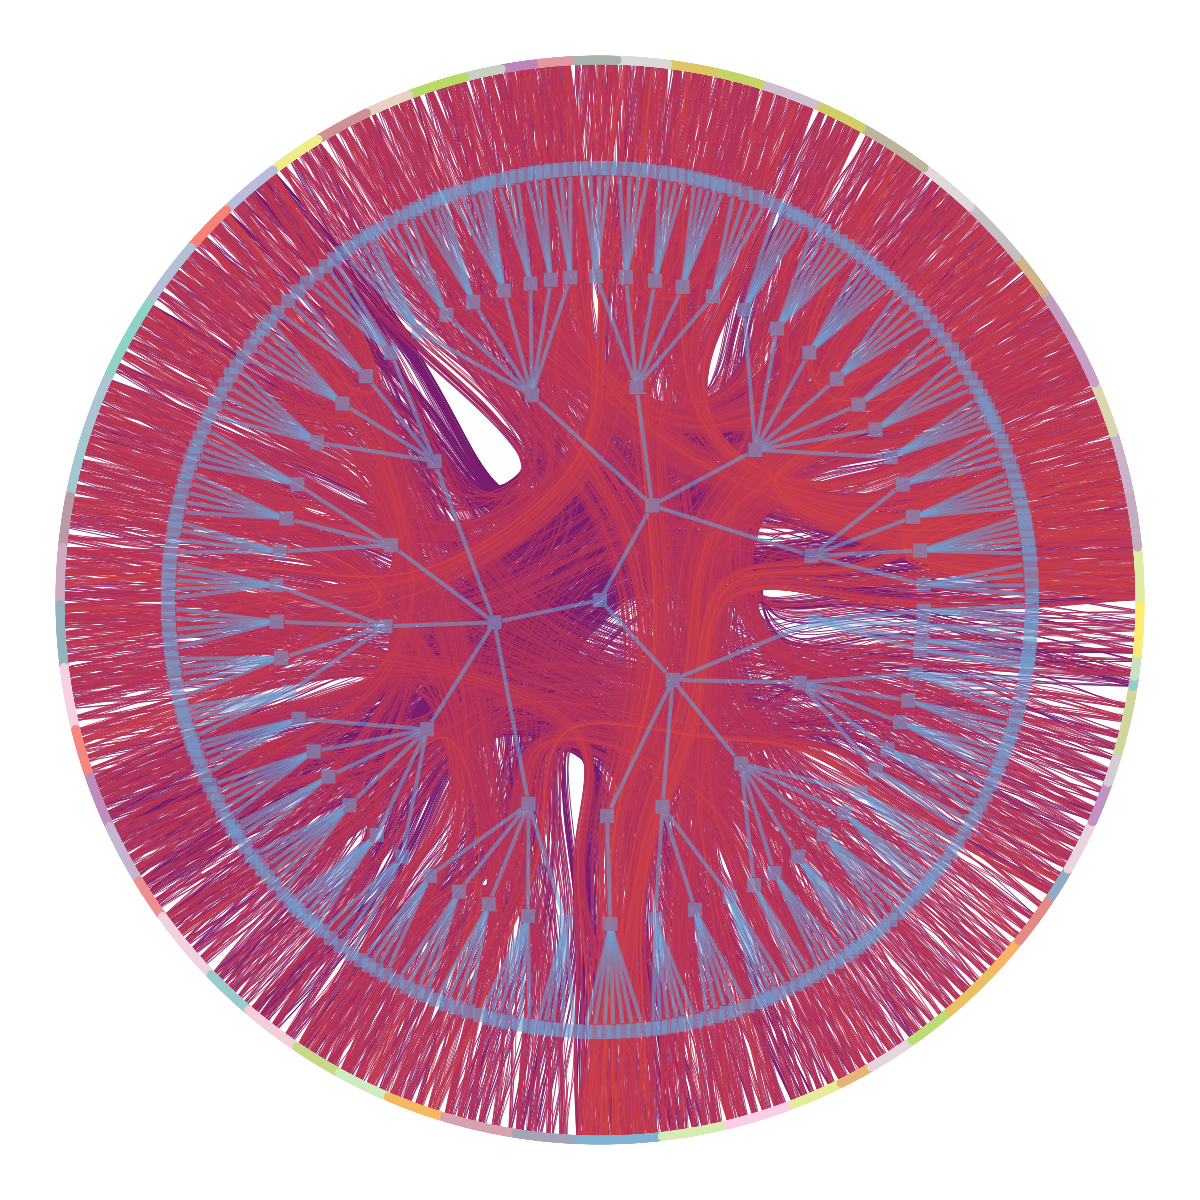

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f340c17bb20, at 0x7f340e06b040>,
 <Graph object, directed, with 6282 vertices and 6281 edges, at 0x7f340e042860>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f340e042860, at 0x7f340e043010>)

In [66]:
g2.vp.level_1 = g2.new_vertex_property("double", state2.get_bs()[1][state2.get_bs()[0]])
state2.draw(eorder=g2.ep.z_s,
           #edge_pen_width = gf_head.ep.z_s,
           #edge_color=prop_to_size(g2.ep.z_s, mi=0, ma=1, power=2, log=False),
           edge_color=prop_to_size(g2.ep.z_s, mi=0, ma=1, power=0.5, log=False),
           ecmap=(mpl.inferno, 0.6), 
           edge_gradient=[], 
           vertex_size = 4,
           hvertex_size = 10,
           hedge_pen_width = 2,
           vertex_color = g2.vp.level_1,
           vertex_fill_color = g2.vp.level_1,
           subsample_edges = 5000)

In [80]:
nested_partition_overlap(bs, bs2)

0.09999999999999998